# Code Assignment 16 — K-Means Clustering (Mall Customers, 2–3 Features Only)

**Format:** Instructor Guidance → Your Task (step-by-step) → We Share (reflection)

**Goal:** Build a **K-Means** clustering model using **only 2–3 simple numeric features** with **minimal cleaning**, pick **K** via **Elbow + Silhouette** on the **train split**, and sanity-check **generalization** on the **test split**. Then profile clusters in plain business terms.

**Dataset (simple, non-transportation):** *Mall Customers* (public, widely used teaching dataset)  

> We will only use **2–3 numeric columns**: e.g., `Age`, `Annual Income (k$)`, `Spending Score (1-100)`.  



## Instructor Guidance (Pseudocode + Docs)

**Docs:**  
- `train_test_split`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- `StandardScaler`: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html  
- `KMeans`: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html  
- `silhouette_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

### Pseudocode Plan (Minimal)
1) **Load CSV** → preview columns/shape.  
2) **Pick 2–3 numeric features** (e.g., Age, Income, SpendingScore).  
3) **Drop NA only** on those columns.  
4) **Split**: `train_test_split(X, test_size=0.2, random_state=42)`.  
5) **Scale**: `StandardScaler` — **fit on TRAIN**, transform TRAIN and TEST.  
6) **Choose K** on TRAIN: loop K=2..8 → plot **Elbow (inertia)** and **Silhouette**.  
7) **Fit final KMeans** on TRAIN with your chosen K; predict TRAIN & TEST labels.  
8) **Sanity check**: report **Silhouette (TRAIN vs TEST)**.  
9) **Profile clusters**: per-cluster means of your 2–3 features (no extra cleaning).  
10) **Reflection**: justify K, describe segments, suggest one action per segment.


## Your Task — Step-by-Step
Work in pairs. Keep code minimal. Use only 2–3 features.

### 1) Imports & Settings

In [1]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### 2) Load the Mall Customers CSV & Preview

In [2]:
df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/Mall_Customers copy.csv')

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.shape

(200, 5)

In [5]:
df.keys()

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [6]:
df['Annual Income (k$)'].value_counts()

Annual Income (k$)
54     12
78     12
48      6
71      6
63      6
       ..
58      2
59      2
16      2
64      2
137     2
Name: count, Length: 64, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [8]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [9]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

### 3) Select **2–3 Numeric Features** (no heavy cleaning)
Choose from:
- `Age`
- `Annual Income (k$)`
- `Spending Score (1-100)`

> Keep it simple: e.g., use **Age + Spending Score** (2D) or **Age + Income + Spending Score** (3D).


In [12]:
# My features (x)
X = df[['Age', 'Annual Income (k$)']]

### 4) Train–Test Split (for model generalization sanity check)

In [13]:
# train test split with only features, its unsupervised so no y 
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

### What is K-means?
- K = the number of clusters you want the algorithm to find.
    - K-Means takes your data (in this case your customers) and tries to group them into K different groups where each group contains customers who are similar to each other.

#### Example: Mall
- In a mall theres 200 customers. The K-means will try to group those customers into K buckets based on their Age, Income and spending score
    - If K = 2, it will try to ofrm 2 groups
    - If K = 3, it will try to ofrm 3 groups
    - If K = 5, it will try to ofrm 5 groups
- Each group will try to gather customers with similar patterns.

##### Now let's say I choose K = 3
- This means K-means may product 3 clusters such as 
    1. Younger, low-income, low spending
    2. Middle-aged, high-income, high spending
    3. Older, moderate-income, low spending
- You don’t choose the meaning, K-Means finds the groups based on patterns.

#### But how do we know what K to pick?
That’s why we use:
1. Elbow method
    - helps you see where adding more clusters stops improving the model much.
2. Silhouette score
    - tells you how well each point fits into its cluster.
- You try different K values (like 2 through 8), and pick the number that:
    - doesn’t over-split the data
    - makes the clusters tight and well-separated

##### TLDR
- K = how many groups you want.
- K-Means = find K groups based on similarity/patterns
- You pick K using Elbow + Silhouette to avoid bad clustering choices.

### 5) Scale (fit on TRAIN only), then Explore K on TRAIN (Elbow + Silhouette)
- Because K-Means is distance-based, all features must be on the same scale.
- For example: 
    - Income = 90
    - Age = 23
- Income would dominate clustering unless you scale... we don't want that to happen now do we 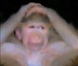

In [14]:
# scale, fit the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)          # fit ONLY on train
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### What does K mean in K-Means?
K is not chosen automatically. You test several values (like 2, 3, 4, 5, 6…) and pick the best one using:
- The Elbow Method (scree plot of inertia)
- The Silhouette Score (how well clusters are separated, higher is better)
- Then you justify:
    - I picked K=3 because the elbow stabilized at 3 and silhouette was highest at K=3.

# 6) Choose **K** (justify), Fit Final Model on TRAIN, Check Stability on TEST
- Report **Silhouette TRAIN vs TEST** (higher is better; similar values suggest stability).

## What is elbow method? 
- Imagine you are trying to group customers into clusters. You try different values of K (number of clusters):
- K = 1, K = 2, K = 3, K = 4, K = 5
    - For each K, K-Means calculates something called inertia.

#### But what is inertia? 
- Inertia = how tightly the points in a cluster are grouped together.
    - Lower inertia = tighter clusters = better.
- **But inertia always decreases as you increase K.**
    - Because the more clusters you make, the easier it is to group things tightly.
    - So you can’t just choose the lowest inertia.

#### So what does the Elbow Method actually do?
- You plot:
    - K value (x-axis)
    - Inertia (y-axis)

- The graph will look like a downward curve.
    - At FIRST, inertia drops quickly (big improvement).
    - After a while, adding more clusters improves inertia only a tiny bit.
- This creates a shape like an elbow / bent arm.

##### Why does this matter?
You want the smallest K that gives you the biggest improvement.
- Because:
    - Too small K → clusters too broad + messy
    - Too large K -> overfitting + unnecessarily complex
- The **elbow** gives the **sweet spot**

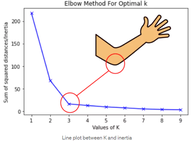

## What is the Silhouette Method?
Silhouette checks how well each point fits in its cluster and how far it is from other clusters; the best K is the one with the highest average silhouette score.
- It’s basically asking each data point two questions:
    1) “Do I belong here?”
        - (Am I close to the points inside my own cluster?)
    2) “Am I far away from other clusters?”
        - (Am I clearly separated from the other groups?)

- It gives each point a score from –1 to +1.
    - +1 -> perfect clustering: The point is very close to its own group and very far from other groups.
    - 0 -> meh: The point is on the border between two clusters.
    - Negative -> bad: The point might be in the wrong cluster.

#### How you use it to pick K
- You run K-means with different values of K:
    - K = 2, K = 3, K = 4, K = 5...
- For each K, you compute the average silhouette score for the entire dataset.
    - Then: You pick the K with the highest average silhouette score.
    - Because that K gives the best-separated, most “coherent” clusters

##### In other words...
- You don’t just compute silhouette for ONE K. You compute it for MANY K values (2, 3, 4, 5 … 10).
- Then you compare the scores. The best K is the one with the highest silhouette score.
- Because it means:
    - ✔ Groups are tight
    - ✔ Groups are well-separated
    - ✔ Clusters actually make sense

#### Analogy example:
- Imagine grouping kids in a school hallway:
    - Elbow method looks at how tightly each group forms.
        - (Are they clumped together nicely?)
    - Silhouette looks at how separate the groups are:
        - (Are the kids in each group standing close to each other and far from other groups?)
        - A good silhouette score means each kid feels like: "Yeah, I’m in the right group.”


In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

Ks = [2, 3, 4, 5, 6, 7, 8, 9]

inertias = []
silhouettes = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_train_scaled)

    inertias.append(km.inertia_)  
    silhouettes.append(silhouette_score(X_train_scaled, km.labels_))

    print(f"K={k} → Inertia={km.inertia_:.2f}, Silhouette={silhouette_score(X_train_scaled, km.labels_):.3f}")

K=2 → Inertia=198.12, Silhouette=0.377
K=3 → Inertia=101.79, Silhouette=0.458
K=4 → Inertia=76.78, Silhouette=0.439
K=5 → Inertia=62.45, Silhouette=0.401
K=6 → Inertia=55.69, Silhouette=0.377
K=7 → Inertia=45.16, Silhouette=0.387
K=8 → Inertia=39.54, Silhouette=0.375
K=9 → Inertia=31.77, Silhouette=0.398


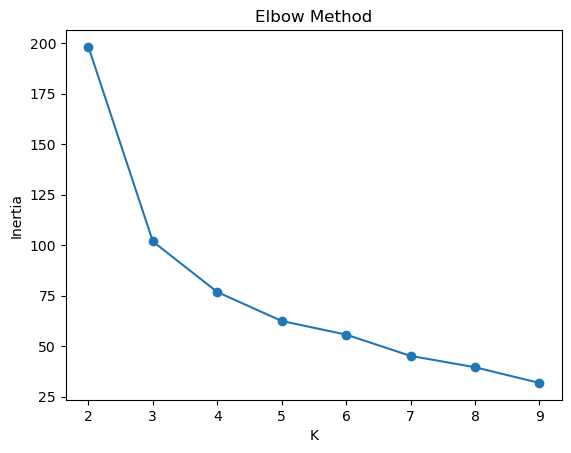

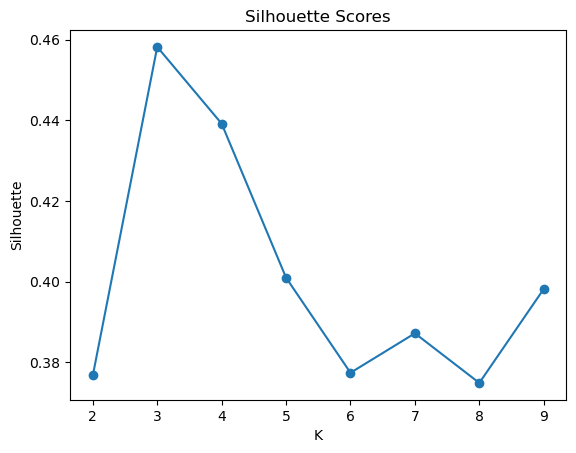

In [ ]:
# Plot inertia
plt.plot(Ks, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

# Plot silhouette
plt.plot(Ks, silhouettes, marker='o')
plt.title("Silhouette Scores")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()


### K = 3
- I feel so smart 
- this is me right now
- 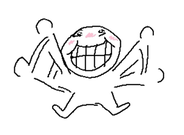

### 7) Profile Clusters (Business-Readable)
- Use the **original (unscaled)** features for interpretation.
- Show per-cluster means of your **2–3 features**.

In [32]:
# get customer labels for each customer
final_kmeans = KMeans(n_clusters=3, random_state=42)
final_kmeans.fit(X_train_scaled)

train_labels = final_kmeans.labels_

In [ ]:
# get the labels
train_labels = final_kmeans.labels_

# attach labels to the ORIGINAL data
train_with_clusters = X_train.copy()
train_with_clusters['cluster'] = train_labels

# cluster profiles
cluster_profiles = train_with_clusters.groupby('cluster').mean()
cluster_profiles


,Age,Annual Income (k$)
cluster,,
0,27.200000,37.500000
1,55.711538,52.500000
2,33.948276,87.793103


In [ ]:
from sklearn.metrics import silhouette_score

train_labels = final_kmeans.predict(X_train_scaled)
test_labels = final_kmeans.predict(X_test_scaled)


sil_train = silhouette_score(X_train_scaled, train_labels)
sil_test  = silhouette_score(X_test_scaled, test_labels)

print("Silhouette TRAIN:", sil_train)
print("Silhouette TEST:", sil_test)


Silhouette TRAIN: 0.4582029471153454
Silhouette TEST: 0.39663642794698717


Using the original, unscaled data, I calculated the average Age, Income, and Spending Score for each cluster. These profiles help describe the types of customers in each group and make the clusters interpretable for business decisions.

#### What the table reveals:
- There are 3 clustersL 0, 1, 2
- Cluster 0:
    - For average age ~27, lower-income (~37K)
- Cluster 1: 
    - Older age ~55, moderate-income customers (~52K)
- Cluster 2:
    - Middle aged ~34, high-income customers (~88)

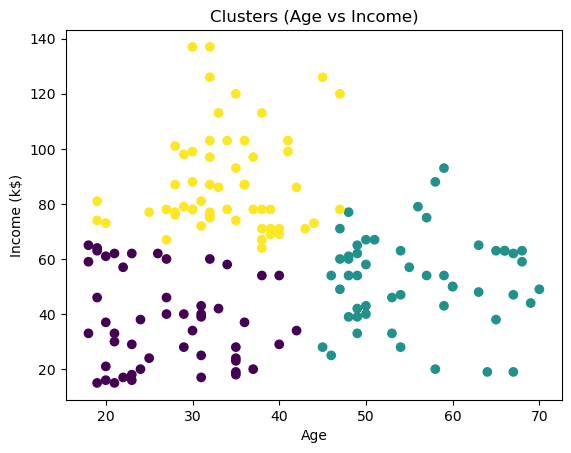

In [ ]:
labels = final_kmeans.predict(X_train_scaled)
df_train = X_train.copy()
df_train['cluster'] = labels
df_train.groupby('cluster').mean()

cluster_means = df_train.groupby('cluster').mean()

plt.scatter(df_train['Age'], df_train['Annual Income (k$)'], c=df_train['cluster'], cmap='viridis')
plt.xlabel("Age")
plt.ylabel("Income (k$)")
plt.title("Clusters (Age vs Income)")
plt.show()

## We Share — Reflection (2 short paragraphs)

1) **K choice & stability:** What **K** did you choose and why (Elbow bend, Silhouette peak/plateau, simplicity)? Report **Silhouette (TRAIN vs TEST)** — did structure persist, or did it collapse on test?  
    - I choose k=3 because based on my Elbow bend, the line bends at 3, and it was the smallest K with the biggest improvement. Also, the Silhouetee peak reveals that 3 was the highest average, so it confirmed that 3 is the correct number. To check stability, I compared the Silhouette score on the trian split versus the test split. My train Silhouette was 0.458, and the test Silhouette was 0.397. Hence, the values are fairly close, meaning the clusters learned on train data still hold their shape on unseen test data. The slight drop is normal, but because the structure did not collapse, this suggests that K=3 is stable and generalizes well.
2) **Segments & actions:** Give short names to your segments (e.g., “Young High-Spend,” “Mid-Age Value-Seeker,” “Older Low-Spend”) and suggest **one actionable idea** for each (targeted offers, product mix, messaging).
- Cluster 0:
    - Average age ~27, lower-income (~37K)
        - "Young low-spender"
        - I'd offer discounts, coupons, offer sales through marketing strategies (e.g., emails, text messages, ads, sign-up for awards system if there is one)
- Cluster 1: 
    - Older age ~55, moderate-income customers (~52K)
        - "Older moderate-spender"
        - I'd sent targeted offers (knowing your audience and what customers prefer is important, make it a more personalized shopping experience)
        - Since they are spending moderately high, I'd mail coupons, also they are on the older side (they may prefer to mailed stuff over emails)
        - I can also send loyalty offers
- Cluster 2:
    - Middle aged ~34, high-income customers (~88)
        - "Mid-age high-spender"
        - Promote premium products or exclusive perks (VIP sales, early access, higher-end product recommendations). This group has the budget and interest to respond to luxury-leaning offers. 

> Bonus: Re-run with **just 2 features** (e.g., **Income + SpendingScore**) and compare stability & interpretability.
